In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skimage.filters import threshold_otsu
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

from pathlib import Path
import json
import os

In [2]:
base_dir = Path().resolve()
base_dir

PosixPath('/home/sadegh/python_projects/nencki_institute/notebooks')

## Patient Measurement Analysis

In [3]:
patient_1991 = base_dir.parent / "data/measurements_1991.xlsx"
patinet_3149 = base_dir.parent / "data/measurements_3149.csv"

In [4]:
# patient 1991
raw = pd.read_excel(patient_1991, header=None)
header = raw.iloc[0,0].split(";")
raw.columns = header
raw["Cell: ALDH1L1: Median"] = raw["Cell: ALDH1L1: Median"].astype(str).str.extract(r"([-+]?\d*\.?\d+)")[0]
raw["Cell: ALDH1L1: Median"] = pd.to_numeric(raw["Cell: ALDH1L1: Median"], errors="coerce")
raw = raw.iloc[3:,:]
df_1991 = raw.reset_index(drop=True)
df_1991

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Cell: Area µm^2,...,Cell: LGALS3: Mean,Cell: LGALS3: Median,Cell: PD-1: Mean,Cell: PD-1: Median,Cell: MOG: Mean,Cell: MOG: Median,Cell: SPP1: Mean,Cell: SPP1: Median,Cell: ALDH1L1: Mean,Cell: ALDH1L1: Median
0,pHGG_1991_3149_Scan1.qptiff - resolution #1,533b814e-ea83-4609-b853-803f539f6d7a,Cell,NaN,NaN,Annotation,Polygon,9802.9,29434.9,7.1667,...,5.1875,5.0,0.0312,0.0,0.0625,0.0,0.0000,0.0,91.9375,87.5
1,pHGG_1991_3149_Scan1.qptiff - resolution #1,df62610a-34eb-4783-a4d5-cf0e1422ea4c,Cell,NaN,NaN,Annotation,Polygon,9811.3,29444.0,41.3081,...,3.9057,4.0,0.3145,0.0,0.0189,0.0,0.0440,0.0,78.6792,79.0
2,pHGG_1991_3149_Scan1.qptiff - resolution #1,b1aa9611-8c01-4076-8be8-41c004b0dd6c,Cell,NaN,NaN,Annotation,Polygon,9805.1,29451.4,49.0177,...,4.0950,4.0,0.5250,0.0,0.0100,0.0,0.1850,0.0,88.2250,95.5
3,pHGG_1991_3149_Scan1.qptiff - resolution #1,878f8f4d-2a58-4d32-b2ae-e61f110c4e96,Cell,NaN,NaN,Annotation,Polygon,9802.0,29467.5,54.7391,...,4.1396,4.0,0.4910,0.0,1.2477,0.0,0.1847,0.0,97.0045,101.0
4,pHGG_1991_3149_Scan1.qptiff - resolution #1,859744c8-8e91-4edf-991b-8e367fc810c1,Cell,NaN,NaN,Annotation,Polygon,9813.3,29470.4,59.0107,...,3.9339,4.0,0.2467,0.0,0.0044,0.0,0.1013,0.0,68.8987,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31405,pHGG_1991_3149_Scan1.qptiff - resolution #1,1d81db57-b450-4f7d-8e61-29a7499964f2,Cell,NaN,NaN,Annotation,Polygon,13444.7,28702.3,53.1763,...,5.9628,6.0,0.9860,1.0,0.0326,0.0,0.1721,0.0,100.4512,84.0
31406,pHGG_1991_3149_Scan1.qptiff - resolution #1,97110e29-2c24-4b4d-9d98-4b607c2285ca,Cell,NaN,NaN,Annotation,Polygon,12702.9,27801.7,58.2237,...,4.4895,4.0,0.5021,0.0,0.0042,0.0,0.4226,0.0,19.0586,20.0
31407,pHGG_1991_3149_Scan1.qptiff - resolution #1,554a57d3-7267-46e4-a09f-5e8b53d95599,Cell,NaN,NaN,Annotation,Polygon,13245.2,28465.8,13.0345,...,5.8302,6.0,0.8302,1.0,0.0566,0.0,0.9245,1.0,87.2076,86.0
31408,pHGG_1991_3149_Scan1.qptiff - resolution #1,19de3283-0860-454a-960e-a775eb1b9ca6,Cell,NaN,NaN,Annotation,Polygon,12396.3,28610.3,65.7426,...,9.6525,9.0,0.9151,1.0,0.0077,0.0,0.5019,0.0,75.1583,64.0


In [5]:
# patient_3149
raw = pd.read_csv(patinet_3149, header=None)   
header = raw.iloc[0, 0].split(";")
data = raw.iloc[1:, 0].str.split(";", expand=True)
data.columns = header
df_3149 = data.reset_index(drop=True)
df_3149

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Cell: Area µm^2,...,Cell: LGALS3: Mean,Cell: LGALS3: Median,Cell: PD-1: Mean,Cell: PD-1: Median,Cell: MOG: Mean,Cell: MOG: Median,Cell: SPP1: Mean,Cell: SPP1: Median,Cell: ALDH1L1: Mean,Cell: ALDH1L1: Median
0,pHGG_1991_3149_Scan1.qptiff - resolution #1,84099414-3e62-425a-9085-282e3e1a21ff,Cell,,,Annotation,Polygon,11200,8391.1,15.3048,...,4.1077,4,0.4769,0,0,0,0.0923,0,21.4923,21
1,pHGG_1991_3149_Scan1.qptiff - resolution #1,fc30177d-09e0-409e-992d-74629ce175ed,Cell,,,Annotation,Polygon,11186.4,8393.8,10.7628,...,3.3478,3,0.0435,0,0,0,0,0,21.087,21
2,pHGG_1991_3149_Scan1.qptiff - resolution #1,310dabff-3574-4189-95d3-f3d84678f548,Cell,,,Annotation,Polygon,11177.7,8396.1,43.6511,...,3.7127,4,0.5249,0,0,0,0.0718,0,18.2376,18
3,pHGG_1991_3149_Scan1.qptiff - resolution #1,0ee07499-3690-418e-9e36-7aad91ae371e,Cell,,,Annotation,Polygon,11203.9,8394.9,68.7307,...,5.1295,5,0.2662,0,0,0,0.0324,0,29.7914,27
4,pHGG_1991_3149_Scan1.qptiff - resolution #1,fb7cd2e6-4853-4c72-9947-1d818f5dd069,Cell,,,Annotation,Polygon,11191,8396.8,83.7356,...,4.7654,5,0.0587,0,0,0,0.7683,0,15.6246,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210548,pHGG_1991_3149_Scan1.qptiff - resolution #1,45dcefff-1dc0-4f66-b57a-673b3f3f623b,Cell,,,Annotation,Polygon,14876.7,13381.4,47.9196,...,7.715,8,1.1192,1,0.0207,0,0.1347,0,170.1347,167
210549,pHGG_1991_3149_Scan1.qptiff - resolution #1,6405fd5b-8e04-49ca-a121-fc0cc80d4771,Cell,,,Annotation,Polygon,15572.4,13598.9,30.4987,...,2.9297,3,0.8438,1,0.0234,0,0.1094,0,148.2266,142
210550,pHGG_1991_3149_Scan1.qptiff - resolution #1,ed7ac5ab-f6f4-4ff5-bb8c-b0b69f2f9ea2,Cell,,,Annotation,Polygon,14641,14067.6,61.5644,...,2.1734,2,1.0927,1,0.0081,0,0.1452,0,134.9839,135
210551,pHGG_1991_3149_Scan1.qptiff - resolution #1,d8ac877d-1955-4fc6-8f9d-93d86c423df5,Cell,,,Annotation,Polygon,14772.3,13626,23.1197,...,2.44,2,0.59,0,0,0,0.06,0,251.36,255


In [6]:
df_3149.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210553 entries, 0 to 210552
Data columns (total 69 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Image                    210553 non-null  object
 1   Object ID                210553 non-null  object
 2   Object type              210553 non-null  object
 3   Name                     210553 non-null  object
 4   Classification           210553 non-null  object
 5   Parent                   210553 non-null  object
 6   ROI                      210553 non-null  object
 7   Centroid X µm            210553 non-null  object
 8   Centroid Y µm            210553 non-null  object
 9   Cell: Area µm^2          210553 non-null  object
 10  Cell: Length µm          210553 non-null  object
 11  Cell: Circularity        210553 non-null  object
 12  Cell: Solidity           210553 non-null  object
 13  Nucleus: DAPI: Mean      210553 non-null  object
 14  Nucleus: DAPI: Media

## EDA on datasets

#### Define which patient to analyze

In [7]:
data = df_3149 #  df_3149 or df_1991

In [8]:
for col in data.columns:
    if "Mean" in col or "Median" in col:
        data[col] = pd.to_numeric(data[col], errors="coerce")

In [9]:
data.columns

Index(['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent',
       'ROI', 'Centroid X µm', 'Centroid Y µm', 'Cell: Area µm^2',
       'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity',
       'Nucleus: DAPI: Mean', 'Nucleus: DAPI: Median', 'Nucleus: H3K27M: Mean',
       'Nucleus: H3K27M: Median', 'Nucleus: Ki67: Mean',
       'Nucleus: Ki67: Median', 'Cell: GLUT1: Mean', 'Cell: GLUT1: Median',
       'Cell: GFAP: Mean', 'Cell: GFAP: Median', 'Cell: CD163: Mean',
       'Cell: CD163: Median', 'Cell: SOX4: Mean', 'Cell: SOX4: Median',
       'Cell: CD31: Mean', 'Cell: CD31: Median', 'Cell: TMEM119: Mean',
       'Cell: TMEM119: Median', 'Cell: HLA-A: Mean', 'Cell: HLA-A: Median',
       'Cell: CD68: Mean', 'Cell: CD68: Median', 'Cell: CD20: Mean',
       'Cell: CD20: Median', 'Cell: CD4: Mean', 'Cell: CD4: Median',
       'Cell: CD8: Mean', 'Cell: CD8: Median', 'Cell: GPNMB: Mean',
       'Cell: GPNMB: Median', 'Cell: PD-L1: Mean', 'Cell: PD-L1: Median',
     

### Preprocessing on Data

In [10]:
cell_missing_thresh = 0.3   # drop cell if >30% markers missing
marker_missing_thresh = 0.5 # drop marker if >50% missing

def preprocess_multiplex_data(df, numeric_cols=None, scaler_type="robust"):
    """
    Preprocess multiplex biomarker intensities per cell.
    
    Steps:
    1. Drop cells with too many missing markers
    2. Drop markers with too many missing values
    3. Drop any rows (cells) with NaN in numeric features
    4. Impute missing values with median
    5. Scaling (StandardScaler or RobustScaler)
    """

    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    
    # --- drop markers with too many missing values
    valid_markers = [m for m in numeric_cols 
                     if df[m].isna().mean() < marker_missing_thresh]
    print(f"Keeping {len(valid_markers)} markers out of {len(numeric_cols)}")

    # --- drop cells with too many missing values
    row_na_fraction = df[valid_markers].isna().mean(axis=1)
    df = df.loc[row_na_fraction < cell_missing_thresh].copy()
    print(f"Remaining cells after missing-threshold filter: {df.shape[0]}")

    # --- drop any rows with NaN in numeric columns
    df = df.dropna(subset=valid_markers)
    print(f"Remaining cells after dropping NaN rows: {df.shape[0]}")

    # --- impute missing with per-marker median (just in case some left)
    imputer = SimpleImputer(strategy="median")
    X = imputer.fit_transform(df[valid_markers])
    df[valid_markers] = X

    # --- scaling
    if scaler_type == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    df[valid_markers] = scaler.fit_transform(df[valid_markers])

    return df, valid_markers

In [11]:
processed_df, used_markers = preprocess_multiplex_data(data)

Keeping 56 markers out of 56
Remaining cells after missing-threshold filter: 210374
Remaining cells after dropping NaN rows: 172205


### Apply Thresholding Methods on Markers

In [12]:
def compute_thresholds(data, markers, 
                       methods=["otsu", "gmm", "percentile", "zscore", "log_percentile", "robust_zscore", "manual"],
                       percentile=90, 
                       zscore=2, 
                       manual_thr=None, 
                       save_plots=True,
                       outdir="thresholds"):
    """
    Compute thresholds for multiple markers with different methods,
    extended with log-percentile, robust-zscore, and manual thresholding.

    Parameters
    ----------
    data : pd.DataFrame
        QuPath measurement table containing intensity columns.
    markers : list
        List of marker names.
    methods : list
        Thresholding methods to apply.
    percentile : int
        Percentile cutoff for 'percentile' method.
    zscore : float
        Z-score multiplier for 'zscore' and 'robust_zscore'.
    manual_thr : float or dict, optional
        - If float → same manual threshold for all markers & compartments.
        - If dict {marker: value} → marker-specific threshold.
        - If dict {marker: {compartment: value}} → marker+compartment-specific threshold.
    save_plots : bool
        Whether to save histograms with thresholds overlaid.
    outdir : str
        Directory to save plots.

    Returns
    -------
    thresholds_df : pd.DataFrame
        Summary table of thresholds per marker & compartment.
    TH : dict
        Nested dict of thresholds for each method.
    """

    if save_plots:
        os.makedirs(outdir, exist_ok=True)

    results = []
    TH = {}

    for marker in markers:
        TH[marker] = {}

        for compartment in ["Cell", "Nucleus"]:
            col = f"{compartment}: {marker}: Mean"
            if col not in data.columns:
                continue

            values = data[col].dropna().values
            if len(values) == 0:
                continue

            thr_dict = {"Marker": marker, "Compartment": compartment}
            TH[marker][compartment] = {}

            for method in methods:
                thr = None

                # --- Otsu ---
                if method == "otsu":
                    thr = threshold_otsu(values)

                # --- Gaussian Mixture Model ---
                elif method == "gmm":
                    gmm = GaussianMixture(n_components=2, random_state=42)
                    gmm.fit(values.reshape(-1, 1))
                    means = np.sort(gmm.means_.flatten())
                    thr = np.mean(means)

                # --- Percentile ---
                elif method == "percentile":
                    thr = np.percentile(values, percentile)

                # --- Log Percentile ---
                elif method == "log_percentile":
                    log_vals = np.log1p(values[values > 0])
                    thr = np.expm1(np.percentile(log_vals, percentile))

                # --- Z-score ---
                elif method == "zscore":
                    mean = values.mean()
                    std = values.std()
                    thr = mean + zscore * std

                # --- Robust Z-score ---
                elif method == "robust_zscore":
                    median = np.median(values)
                    mad = np.median(np.abs(values - median))
                    thr = median + zscore * mad

                # --- Manual thresholding ---
                elif method == "manual":
                    if manual_thr is None:
                        continue

                    if isinstance(manual_thr, (int, float)):
                        thr = manual_thr
                    elif isinstance(manual_thr, dict):
                        # case 1: {marker: value}
                        if marker in manual_thr and isinstance(manual_thr[marker], (int, float)):
                            thr = manual_thr[marker]
                        # case 2: {marker: {compartment: value}}
                        elif marker in manual_thr and isinstance(manual_thr[marker], dict):
                            thr = manual_thr[marker].get(compartment, None)

                # skip if no threshold
                if thr is None:
                    continue

                thr_dict[method] = thr
                TH[marker][compartment][method] = thr

                # --- Save histogram plot ---
                if save_plots:
                    plt.figure(figsize=(6, 4))
                    plt.hist(values, bins=100, alpha=0.7, color="gray")
                    plt.axvline(thr, color="red", linestyle="--", label=f"{method} = {thr:.2f}")
                    plt.title(f"{marker} ({compartment}) - {method}")
                    plt.xlabel("Intensity")
                    plt.ylabel("Cell count")
                    plt.legend()
                    fname = f"{marker}_{compartment}_{method}.png".replace(" ", "_")
                    plt.savefig(os.path.join(outdir, fname), dpi=150, bbox_inches="tight")
                    plt.close()

            results.append(thr_dict)

    thresholds_df = pd.DataFrame(results).set_index(["Marker", "Compartment"])
    return thresholds_df, TH


In [13]:
def plot_all_thresholds(values, thresholds_dict, marker, compartment, outdir, focus_percentile=80, show=True):
    """
    values: intensity values (list or np.array)
    thresholds_dict: dict of {method_name: threshold_value}
    marker: e.g. "SPP1"
    compartment: e.g. "cell"
    outdir: output directory
    focus_percentile: zoom 
    """

    os.makedirs(outdir, exist_ok=True)

    plt.figure(figsize=(6,4))
    plt.hist(values, bins=100, alpha=0.7, color="gray")

    method_colors = {
        "Otsu": "red",
        "GMM": "blue",
        "Percentile-90": "green",
        "Z-score": "purple",
        "Robust Z-score": "cyan",
        "Manual": "black"
    }

    for method, thr in thresholds_dict.items():
        color = method_colors.get(method, "orange") 
        plt.axvline(thr, linestyle="--", color=color, label=f"{method} = {thr:.2f}")

    xmax = np.percentile(values, focus_percentile)
    plt.xlim(0, xmax)

    plt.title(f"{marker} ({compartment}) - all thresholds")
    plt.xlabel("Intensity")
    plt.ylabel("Cell count")
    plt.legend()

    fname = f"{marker}_{compartment}_all.png".replace(" ", "_")
    plt.savefig(os.path.join(outdir, fname), dpi=150, bbox_inches="tight")

    if show:
        plt.show()

    plt.close()

In [14]:
markers = ["SPP1", "TMEM119", "CD68", "CD45", "LGALS3", "H3K27M", "GLUT1", "CD31"]


thresholds_df, TH = compute_thresholds(processed_df, 
                                       markers,
                                       methods=["otsu", "gmm", "percentile", "zscore", "robust_zscore","manual"],
                                       percentile=90,
                                       zscore=2,
                                       manual_thr={
                                        "SPP1": 0.45, # manual
                                        "TMEM119": 19, # manual
                                        "CD68": 12, # manual
                                        "CD45": 23, # manual
                                        "LGALS3": 6.5 , # manual
                                        "H3K27M": 2.5 , # manual
                                        "GLUT1": 14 , # manual
                                        "CD31": 2.7 # manual
                                       },
                                       save_plots=True
                                       )

thresholds_df

,,otsu,gmm,percentile,zscore,robust_zscore,manual
Marker,Compartment,,,,,,
SPP1,Cell,1.738634,1.441207,1.433830,3.073390,0.893756,0.45
TMEM119,Cell,5.960474,2.571918,3.348659,7.324134,0.772975,19.00
CD68,Cell,2.512518,1.363134,2.365791,4.306071,0.858177,12.00
CD45,Cell,3.162057,1.978906,2.040900,4.544489,0.996436,23.00
LGALS3,Cell,0.521237,0.395206,1.289033,1.903320,0.912096,6.50
H3K27M,Nucleus,0.619764,0.282490,1.401414,1.794461,0.893095,2.50
GLUT1,Cell,13.648964,6.009686,3.233065,13.887118,0.908716,14.00
CD31,Cell,8.043723,3.612991,1.496649,7.044570,0.984474,2.70


In [17]:
markers = thresholds_df.index.get_level_values(0).tolist()
compartments = thresholds_df.index.get_level_values(1).tolist()

output_dir = "dist/"

for marker in markers:
    for compartment in compartments:
        try:
            row = thresholds_df.loc[(marker, compartment)]

            thresholds = {
                "Otsu": row["otsu"],
                "GMM": row["gmm"],
                "Percentile-90%": row["percentile"],
                "Z-score": row["zscore"],
                "Robust Z-score": row["robust_zscore"],
                "Manual": row["manual"]
            }

            col = f"{compartment}: {marker}: Mean"
            if col not in processed_df.columns:
                print(f"⚠️ Column {col} not found in data, skipping...")
                continue

            values = processed_df[col].dropna().values.reshape(-1, 1)

            plot_all_thresholds(
                values,
                thresholds,
                marker,
                compartment,
                output_dir,
                focus_percentile=99,
                show=False   
            )

            print(f"✅ Done: {marker} - {compartment}")

        except KeyError:
            print(f"⚠️ No thresholds found for {marker}, {compartment}")


✅ Done: SPP1 - Cell
✅ Done: SPP1 - Cell
✅ Done: SPP1 - Cell
✅ Done: SPP1 - Cell
✅ Done: SPP1 - Cell
⚠️ No thresholds found for SPP1, Nucleus
✅ Done: SPP1 - Cell
✅ Done: SPP1 - Cell
✅ Done: TMEM119 - Cell
✅ Done: TMEM119 - Cell
✅ Done: TMEM119 - Cell
✅ Done: TMEM119 - Cell
✅ Done: TMEM119 - Cell
⚠️ No thresholds found for TMEM119, Nucleus
✅ Done: TMEM119 - Cell
✅ Done: TMEM119 - Cell
✅ Done: CD68 - Cell
✅ Done: CD68 - Cell
✅ Done: CD68 - Cell
✅ Done: CD68 - Cell
✅ Done: CD68 - Cell
⚠️ No thresholds found for CD68, Nucleus
✅ Done: CD68 - Cell
✅ Done: CD68 - Cell
✅ Done: CD45 - Cell
✅ Done: CD45 - Cell
✅ Done: CD45 - Cell
✅ Done: CD45 - Cell
✅ Done: CD45 - Cell
⚠️ No thresholds found for CD45, Nucleus
✅ Done: CD45 - Cell
✅ Done: CD45 - Cell
✅ Done: LGALS3 - Cell
✅ Done: LGALS3 - Cell
✅ Done: LGALS3 - Cell
✅ Done: LGALS3 - Cell
✅ Done: LGALS3 - Cell
⚠️ No thresholds found for LGALS3, Nucleus
✅ Done: LGALS3 - Cell
✅ Done: LGALS3 - Cell
⚠️ No thresholds found for H3K27M, Cell
⚠️ No threshold

In [23]:
def pos(data, marker, method="otsu", compartment="Cell",relax=1):
    """
    Return boolean mask of positive cells for a given marker.
    
    Parameters
    ----------
    data : pd.DataFrame
        QuPath measurement table.
    marker : str
        Marker name, e.g. "CD68"
    method : str
        Thresholding method key, e.g. "otsu", "gmm"
    compartment : str
        "Cell" or "Nucleus"
    """
    col = f"{compartment}: {marker}: Mean"
    thr = TH[marker][compartment][method]
    return data[col] > (thr * relax)

In [24]:
# Groups
method = "manual"  # "otsu", "gmm", "percentile", "zscore", "robust_zscore", "manual"

tmem119 = pos(data, "TMEM119", method, "Cell") & \
                 pos(data, "CD68", method, "Cell") & \
                 pos(data, "CD45", method, "Cell")

lgals3 = pos(data, "LGALS3", method, "Cell") & \
                  pos(data, "CD68", method, "Cell") & \
                  pos(data, "CD45", method, "Cell")

h3k27m = pos(data, "H3K27M", method, "Nucleus")

hypoxic = pos(data, "GLUT1", method, "Cell") & (~pos(data, "CD31", method, "Cell"))

# Results dictionary
results = {}

results["SPP1 in TMEM119+ CD68+ CD45+"] = (
    pos(data.loc[tmem119], "SPP1", method, "Cell").mean() * 100
)

results["SPP1 in TMEM119+ CD68+ CD45+ GLUT1+ CD31-"] = (
    pos(data.loc[tmem119 & hypoxic], "SPP1", method, "Cell").mean() * 100
)

results["SPP1 in LGALS3+ CD68+ CD45+"] = (
    pos(data.loc[lgals3], "SPP1", method, "Cell").mean() * 100
)

results["SPP1 in LGALS3+ CD68+ CD45+ GLUT1+ CD31-"] = (
    pos(data.loc[lgals3 & hypoxic], "SPP1", method, "Cell").mean() * 100
)

results["SPP1 in H3K27M+"] = (
    pos(data.loc[h3k27m], "SPP1", method, "Cell").mean() * 100
)

results["SPP1 in H3K27M+ GLUT1+ CD31-"] = (
    pos(data.loc[h3k27m & hypoxic], "SPP1", method, "Cell").mean() * 100
)


# Summary DataFrame
summary = pd.DataFrame.from_dict(results, orient="index", columns=["% SPP1+"])
summary["% SPP1+"] = summary["% SPP1+"].fillna("No cells")
summary.reset_index(inplace=True, names=["Group"])
summary

,Group,% SPP1+
0,SPP1 in TMEM119+ CD68+ CD45+,41.980337
1,SPP1 in TMEM119+ CD68+ CD45+ GLUT1+ CD31-,26.666667
2,SPP1 in LGALS3+ CD68+ CD45+,35.562599
3,SPP1 in LGALS3+ CD68+ CD45+ GLUT1+ CD31-,5.084746
4,SPP1 in H3K27M+,8.764391
5,SPP1 in H3K27M+ GLUT1+ CD31-,3.162753


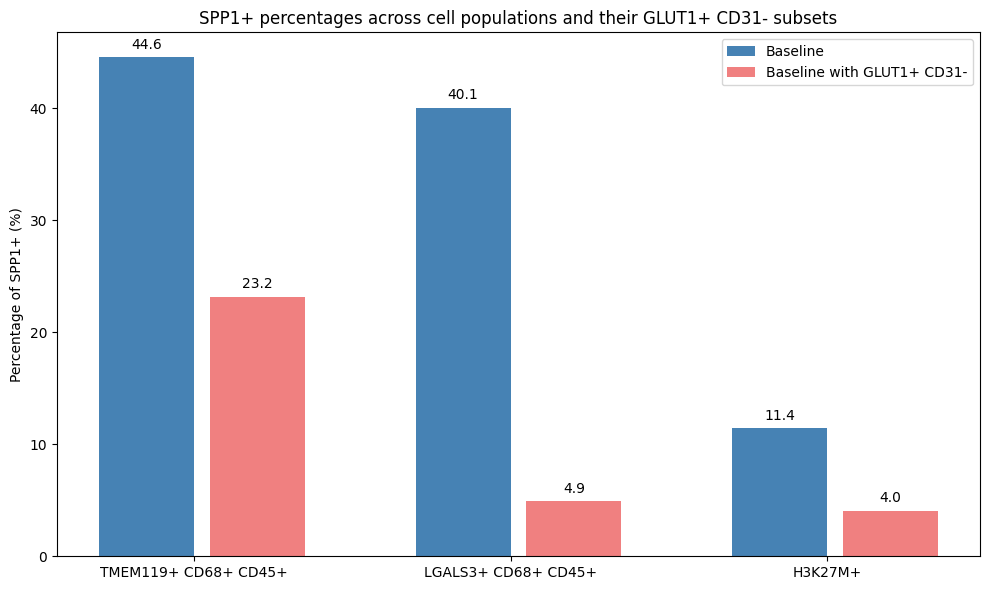

In [20]:
groups = [
    "TMEM119+ CD68+ CD45+", 
    "TMEM119+ CD68+ CD45+ GLUT1+ CD31-",
    "LGALS3+ CD68+ CD45+", 
    "LGALS3+ CD68+ CD45+ GLUT1+ CD31-",
    "H3K27M+", 
    "H3K27M+ GLUT1+ CD31-"
]
values = summary["% SPP1+"]

pairs = [(0,1), (2,3), (4,5)]

plt.figure(figsize=(10,6))

for i, (a, b) in enumerate(pairs):
    x = np.array([i, i+0.35])   
    y = [values[a], values[b]]
    
    plt.bar(x[0], y[0], width=0.3, color="steelblue", label="Baseline" if i == 0 else "")
    plt.bar(x[1], y[1], width=0.3, color="lightcoral", label="Baseline with GLUT1+ CD31-" if i == 0 else "")

    plt.text(x[0], y[0] + 0.5, f"{y[0]:.1f}", ha='center', va='bottom', fontsize=10)
    plt.text(x[1], y[1] + 0.5, f"{y[1]:.1f}", ha='center', va='bottom', fontsize=10)


plt.xticks([i+0.15 for i in range(len(pairs))],
           ["TMEM119+ CD68+ CD45+", "LGALS3+ CD68+ CD45+", "H3K27M+"],
           rotation=0)

plt.ylabel("Percentage of SPP1+ (%)")
plt.title("SPP1+ percentages across cell populations and their GLUT1+ CD31- subsets")
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
def test_significance(data, group_mask, marker="SPP1", method="otsu", compartment="Cell"):
    """
    Compare %SPP1+ between baseline and hypoxic subsets.
    
    Parameters
    ----------
    data : pd.DataFrame
        QuPath measurement table
    group_mask : dict
        Dictionary with masks, e.g. {"microglia": mask1, "microglia_hypoxic": mask2}
    marker : str
        Marker to test positivity for (default="SPP1")
    method : str
        Thresholding method key, e.g. "otsu"
    compartment : str
        "Cell" or "Nucleus"
    
    Returns
    -------
    results : pd.DataFrame
        Table with counts, percentages and p-values
    """
    results = []
    col = f"{compartment}: {marker}: Mean"
    
    for base_name in set(k.split("_hypoxic")[0] for k in group_mask.keys()):
        mask_base = group_mask.get(base_name, None)
        mask_hyp = group_mask.get(base_name + "_hypoxic", None)
        if mask_base is None or mask_hyp is None:
            continue

        # baseline
        base_vals = data.loc[mask_base, col]
        thr = TH[marker][compartment][method]
        base_pos = (base_vals > thr).sum()
        base_neg = (base_vals <= thr).sum()

        # hypoxic subset
        hyp_vals = data.loc[mask_hyp, col]
        hyp_pos = (hyp_vals > thr).sum()
        hyp_neg = (hyp_vals <= thr).sum()

        # contingency table
        table = np.array([[base_pos, base_neg],
                          [hyp_pos, hyp_neg]])

        # chi-square or Fisher depending on counts
        if (table < 5).any():
            oddsratio, pval = fisher_exact(table)
            test = "Fisher"
        else:
            chi2, pval, _, _ = chi2_contingency(table)
            test = "Chi-square"

        results.append({
            "Group": base_name,
            "Baseline %SPP1+": base_pos / (base_pos + base_neg) * 100 if (base_pos+base_neg) > 0 else np.nan,
            "Hypoxic %SPP1+": hyp_pos / (hyp_pos + hyp_neg) * 100 if (hyp_pos+hyp_neg) > 0 else np.nan,
            "Test": test,
            "p-value": pval
        })

    return pd.DataFrame(results)


In [26]:
group_mask = {
    "tmem119": tmem119,
    "tmem119_hypoxic": tmem119 & hypoxic,
    "lgals3": lgals3,
    "lgals3_hypoxic": lgals3 & hypoxic,
    "h3k27m": h3k27m,
    "h3k27m_hypoxic": h3k27m & hypoxic
}

summary_stats = test_significance(data, group_mask, marker="SPP1", method="manual", compartment="Cell")
summary_stats

,Group,Baseline %SPP1+,Hypoxic %SPP1+,Test,p-value
0,tmem119,41.980337,26.666667,Chi-square,4.887186e-04
1,h3k27m,8.764391,3.162753,Chi-square,2.294403e-63
2,lgals3,35.562599,5.084746,Chi-square,1.569941e-16
